In [306]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time 
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation, Dropout
from tensorflow.keras.layers import LSTM

In [307]:
df=pd.read_csv('../input/nyse/prices-split-adjusted.csv')

In [308]:
data.head(5)

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [309]:
data.shape

(851264, 7)

In [310]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
open,851264.0,6.499362e+01,7.520389e+01,1.66,3.127000e+01,4.846000e+01,7.512000e+01,1.584440e+03
close,851264.0,6.501191e+01,7.520122e+01,1.59,3.129278e+01,4.848000e+01,7.514000e+01,1.578130e+03
low,851264.0,6.433654e+01,7.445952e+01,1.50,3.094000e+01,4.797000e+01,7.440000e+01,1.549940e+03
high,851264.0,6.563975e+01,7.590686e+01,1.81,3.162000e+01,4.896000e+01,7.585000e+01,1.600930e+03
volume,851264.0,5.415113e+06,1.249468e+07,0.00,1.221500e+06,2.476250e+06,5.222500e+06,8.596434e+08


In [311]:
data.isnull().sum()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [312]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [313]:
data.dtypes

date       object
symbol     object
open      float64
close     float64
low       float64
high      float64
volume    float64
dtype: object

In [314]:
data.tail(5)

,date,symbol,open,close,low,high,volume
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
851263,2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


# Predict SPecfic stock price data

In [315]:
# choose one stock
stock_data = data[data.symbol == 'AAPL'].copy()

In [316]:
stock=stock_data.reset_index()['close']

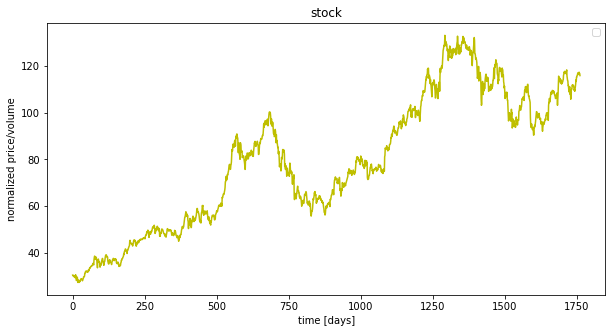

In [317]:
plt.figure(figsize=(10, 5));
plt.plot(stock,color='y')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [318]:
scale=MinMaxScaler(feature_range=(0,1))
stock_scale=scale.fit_transform(np.array(stock).reshape(-1,1))

In [319]:
print(stock_scale)

[[0.02971784]
 [0.03021854]
 [0.02560389]
 ...
 [0.84616011]
 [0.84587593]
 [0.83725556]]


In [320]:
#split the data train test split
##splitting dataset into train and test split
training_size=int(len(stock_scale)*0.65)
test_size=len(stock_scale)-training_size
train_data,test_data=stock_scale[0:training_size,:],stock_scale[training_size:len(stock_scale),:1]

In [321]:
test_size

617

In [322]:
train_data

array([[0.02971784],
       [0.03021854],
       [0.02560389],
       ...,
       [0.63463022],
       [0.62998851],
       [0.63737737]])

In [323]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset,step=1):
    X, Y = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]   ###i=0, 0,1,2,3-----99   100 
        X.append(a)
        Y.append(dataset[i + step, 0])
    return numpy.array(X), numpy.array(Y)

In [324]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [325]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [326]:
X_test

array([[[0.66077544],
        [0.65925975],
        [0.6653224 ],
        ...,
        [0.82115166],
        [0.80059541],
        [0.79746941]],

       [[0.65925975],
        [0.6653224 ],
        [0.6781108 ],
        ...,
        [0.80059541],
        [0.79746941],
        [0.77956563]],

       [[0.6653224 ],
        [0.6781108 ],
        [0.67204815],
        ...,
        [0.79746941],
        [0.77956563],
        [0.76535628]],

       ...,

       [[0.74300023],
        [0.7582516 ],
        [0.76668248],
        ...,
        [0.84900194],
        [0.84170784],
        [0.84388657]],

       [[0.7582516 ],
        [0.76668248],
        [0.77085051],
        ...,
        [0.84170784],
        [0.84388657],
        [0.85089656]],

       [[0.76668248],
        [0.77085051],
        [0.76317748],
        ...,
        [0.84388657],
        [0.85089656],
        [0.84616011]]])

In [359]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [360]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_20 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_21 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [362]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
17/17 [==============================] - 3s 181ms/step - loss: 9.8883e-04 - val_loss: 0.0023
Epoch 2/10
17/17 [==============================] - 3s 183ms/step - loss: 9.3244e-04 - val_loss: 0.0024
Epoch 3/10
17/17 [==============================] - 3s 184ms/step - loss: 9.1404e-04 - val_loss: 0.0021
Epoch 4/10
17/17 [==============================] - 3s 183ms/step - loss: 9.0872e-04 - val_loss: 0.0025
Epoch 5/10
17/17 [==============================] - 3s 180ms/step - loss: 8.7379e-04 - val_loss: 0.0020
Epoch 6/10
17/17 [==============================] - 3s 184ms/step - loss: 9.1880e-04 - val_loss: 0.0020
Epoch 7/10
17/17 [==============================] - 3s 201ms/step - loss: 8.3407e-04 - val_loss: 0.0024
Epoch 8/10
17/17 [==============================] - 3s 190ms/step - loss: 8.4191e-04 - val_loss: 0.0017
Epoch 9/10
17/17 [==============================] - 3s 197ms/step - loss: 7.5542e-04 - val_loss: 0.0016
Epoch 10/10
17/17 [==============================] - 3s 199ms/st

In [363]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [364]:
train_predict.shape

(1044, 1)

In [365]:
test_predict.shape

(516, 1)

In [366]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [367]:
## Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

65.54523811989284

In [368]:
## Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

106.55430878608722

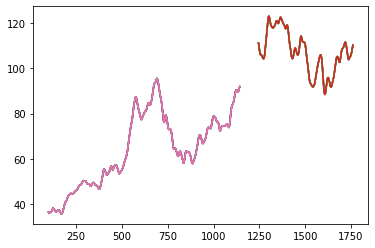

In [372]:
## Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(stock_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(stock_data)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(stock_data)-1, :] = test_predict
# plot baseline and predictions
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [374]:
len(test_data)

617

In [ ]:
len(train_data)